# **Algorithmic Methods of Data Mining - Fall 2022**

## **Homework 4: Getting to know your customers**

**Packages that are used troughout the notebook:**

In [1]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import numpy as np

# Local scripts
import datasets
import lsh

# For progress_apply
tqdm.pandas()

datas = datasets.Datasets()

## 1. Finding Similar Costumers

### 1.1 Set up the data

Starting off, below is the head of the processed transaction dataset. Briefly, we have:
- renamed the columns to make it easier to work with,
- created customer IDs (cid) from scratch, as the original dataset was not consistent with the customer IDs. The new customer IDs are unique identifiers for the customer DOB, location and balance columns. We have made a post about this in the Slack channel,
- merged the transaction date and time into one column, and converted the date to a datetime object.

In [2]:
transactions = datas.getTransactions().copy()
transactions.head()

,tid,cid,cdob,cgender,clocation,cbalance,tdate,tamount
0,T1,0,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02 14:32:07,25.0
1,T2,1,2057-04-04,M,JHAJJAR,2270.69,2016-08-02 14:18:58,27999.0
2,T3,2,1996-11-26,F,MUMBAI,17874.44,2016-08-02 14:27:12,459.0
3,T4,3,1973-09-14,F,MUMBAI,866503.21,2016-08-02 14:27:14,2060.0
4,T5,4,1988-03-24,F,NAVI MUMBAI,6714.43,2016-08-02 18:11:56,1762.5


Below is the head of the customers dataset that was obtained by grouping the transactions dataset by the customer IDs. Since we believe that the DOB, gender, location, and balance are unique for each customer, we did not have to do any aggregation when grouping the transactions dataset.

In [3]:
customers = datas.getCustomers().copy()
customers.head()

,dob,gender,location,balance
cid,,,,
0,1994-01-10,F,JAMSHEDPUR,17819.05
1,1957-04-04,M,JHAJJAR,2270.69
2,1996-11-26,F,MUMBAI,17874.44
3,1973-09-14,F,MUMBAI,866503.21
4,1988-03-24,F,NAVI MUMBAI,6714.43


We will create shingles for each customer by using their age, average transaction amount, and balance. To do this, we are going to divide these variables into 10% quantiles, and assign a quantile to each customer. Therefore, our shingle matrix will consist of $3\times10=30$ rows, and a column for each customer. The values in the matrix will be 1 if the customer belongs to the corresponding quantile, and 0 otherwise.

In [4]:
# Creating the new features
customers['age'] = ((transactions['tdate'].max() - customers['dob']).dt.days // 365).astype(int)
customers['ave_tamount'] = transactions.groupby('cid')['tamount'].mean()

# Creating quantile groups
quantiles = 10
customers['age_group'] = pd.qcut(customers['age'], quantiles, labels=False)
customers['balance_group'] = pd.qcut(customers['balance'], quantiles, labels=False)
customers['tamount_group'] = pd.qcut(customers['ave_tamount'], quantiles, labels=False)

customers.head()

,dob,gender,location,balance,age,ave_tamount,age_group,balance_group,tamount_group
cid,,,,,,,,,
0,1994-01-10,F,JAMSHEDPUR,17819.05,22,80.111111,0,5,0
1,1957-04-04,M,JHAJJAR,2270.69,59,9503.445000,9,2,9
2,1996-11-26,F,MUMBAI,17874.44,19,940.348182,0,5,5
3,1973-09-14,F,MUMBAI,866503.21,43,2537.346923,8,9,8
4,1988-03-24,F,NAVI MUMBAI,6714.43,28,1606.135000,3,3,7


We also have to store the intervals of the quantiles, since we will use them again when querying for similar customers. Futhermore we will need a function that give us the quantile group of a value, given the intervals of the quantiles.

In [5]:
# Store the quantile intervals
age_groups = pd.qcut(customers['age'], quantiles).unique().sort_values()
balance_groups = pd.qcut(customers['balance'], quantiles).unique().sort_values()
tamount_groups = pd.qcut(customers['ave_tamount'], quantiles).unique().sort_values()

# Get the group of a value
def getGroup(group, value):
    return np.where([value in g for g in group])[0][0] if len(np.where([value in g for g in group])[0]) > 0 else None

getGroup(age_groups, 29) # Test: should return 4

4

Now we are going to create our shingle matrix.

In [6]:
# make dummy variables for categorical variables
shingles = pd.DataFrame(index=customers.index)
shingles = pd.concat([shingles, pd.get_dummies(customers['age_group'], prefix='age')], axis=1)
shingles = pd.concat([shingles, pd.get_dummies(customers['balance_group'], prefix='balance')], axis=1)
shingles = pd.concat([shingles, pd.get_dummies(customers['tamount_group'], prefix='tamount')], axis=1)
# transpose to get the shingles
shingles = shingles.T
shingles.head()

cid,0,1,2,3,4,5,6,7,8,9,...,162301,162302,162303,162304,162305,162306,162307,162308,162309,162310
age_0,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
age_1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
age_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
age_3,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
age_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 1.2 Fingerprint hashing

Now that we have our shingle matrix, we can start hashing the rows. We will use the MinHash algorithm to do this. To do so, we will define a function that takes a shingle matrix and number of permuations as the input, and returns the MinHash signature matrix. Note that we are setting the seed of the random number generator, so that we can get the same permutation when querying for similar customers.

In [7]:
# import sparse matrix for shingles
from scipy import sparse

def get_signatures(shingles, signature_length: int) -> np.ndarray:
    # set seed for reproducibility
    np.random.seed(123)
    signatures = np.full((signature_length, shingles.shape[1]), np.nan, dtype=np.int32)
    for i in range(signature_length):

        idx = np.random.choice(shingles.index, shingles.shape[0], replace=False)
        sparse_shingles = sparse.csc_matrix(shingles.loc[idx].values)
        rowidx = sparse_shingles.nonzero()[0]
        colidx = sparse_shingles.nonzero()[1]
        signatures[i,:] = rowidx[np.unique(colidx, return_index=True)[1]]
    return signatures

signatures = get_signatures(shingles, signature_length=40)
print(f'Signatures shape [signature_length, number of customers]: {signatures.shape}')

Signatures shape [signature_length, number of customers]: (40, 162311)


Now, we will put customers in buckets based on their MinHash signatures. We will use the LSH algorithm to do this. We will define a function that takes the MinHash signature matrix, the number of bands, and the number of rows per band as the input, and returns a dictionary with the signatures as the keys, and the customers in the corresponding bucket as the values.

In [8]:
def create_buckets(signatures, band_size):
    buckets = {}
    rows = signatures.shape[0] // band_size
    for i in range(rows):
        for j in range(signatures.shape[1]):
            bucket = (i, *signatures[i*band_size:(i+1)*band_size, j])
            if bucket not in buckets:
                buckets[bucket] = []
            buckets[bucket].append(j)
    return buckets

band_size = 4
buckets = create_buckets(signatures, band_size=2)

print(f'First 5 customers in the first bucket: {buckets[list(buckets.keys())[0]][:5]}')

First 5 customers in the first bucket: [0, 70, 199, 490, 690]


#### 1.3 Locality Sensitive Hashing

Now, we first parse, shingle, shangle and hash the customers dataset, like we did with the transactions dataset. Note that we are using the same intervals of the quantiles as we did for the transactions dataset.

In [9]:
query_users = datas.getQueryUsers()
query_users['age_group'] = query_users['age'].apply(lambda x: getGroup(age_groups, x))
query_users['balance_group'] = query_users['balance'].apply(lambda x: getGroup(balance_groups, x))
query_users['tamount_group'] = query_users['tamount'].apply(lambda x: getGroup(tamount_groups, x))
query_users.index = range(len(query_users))

query_shingles = pd.DataFrame(index=query_users.index)
query_shingles = pd.concat([query_shingles, pd.get_dummies(query_users['age_group'], prefix='age')], axis=1)
query_shingles = pd.concat([query_shingles, pd.get_dummies(query_users['balance_group'], prefix='balance')], axis=1)
query_shingles = pd.concat([query_shingles, pd.get_dummies(query_users['tamount_group'], prefix='tamount')], axis=1)
query_shingles = query_shingles.T

# Add missing rows to query_signatures
for row in shingles.index:
    if row not in query_shingles.index:
        print(f'Adding missing row {row}')
        query_shingles.loc[row] = 0

query_shingles.sort_index(inplace=True)

query_signatures = get_signatures(query_shingles, signature_length=40)
print(f'Query signatures shape [signature_length, number of query users]: {query_signatures.shape}')

Adding missing row balance_0
Query signatures shape [signature_length, number of query users]: (40, 46)


We know that, the probability that the minhash function for a random permutation of rows produces the same value for two sets equals the Jaccard similarity of those sets

We know that, the probability of two customers being in the same bucket is equivalent to the Jaccard similarity of their shingles. Therefore, the match rate of the LSH algorithm is equivalent to the Jaccard similarity of the shingles. We have implemented 3 functions to query similar users:
1. `query_intersection`: This function returns all the customers that are in the exact same buckets given a query customer.
2. `query_unions`: This function returns all the customers that are in the same bucket at least once given a query customer.
3. `query_num_matching_buckets`: This function returns the number of buckets that the query customer is in common with each customer in the dataset.

Using the 3rd function, we can calculate the Jaccard similarity of a query customer, since the number of matches divided by the number of buckets is equivalent to the Jaccard similarity.

In [10]:
band_size = 4
buckets = create_buckets(signatures, band_size=band_size)

lshasher = lsh.LSH(buckets, query_signatures, band_size)

intersections, _ = lshasher.query_intersection()
print('Number of matching customers by intersection for the first 10 queries:')
for i in range(10):
    print(len(intersections[i]), end='\t')


print('\nNumber of matching customers by union for the first 10 queries:')
unions, _ = lshasher.query_unions()
for i in range(10):
    print(len(unions[i]), end='\t')


Number of matching customers by intersection for the first 10 queries:
80	94	321	103	74	116	76	460	201	93	
Number of matching customers by union for the first 10 queries:
1528	6202	3688	2246	924	1117	730	3863	2183	14299	

In [11]:
num_matching_buckets = lshasher.query_num_matching_buckets()

print('Estimated Jaccard similarity for the first 10 customers, for the first query:')
for i in np.random.choice(list(num_matching_buckets[0].keys()), 5):
    print(f'Num matching buckets w/ cid {i}: {num_matching_buckets[0][i]}, \t Jaccard similarity: {num_matching_buckets[0][i] / 10}')

Estimated Jaccard similarity for the first 10 customers, for the first query:
Num matching buckets w/ cid 129152: 1, 	 Jaccard similarity: 0.1
Num matching buckets w/ cid 117042: 1, 	 Jaccard similarity: 0.1
Num matching buckets w/ cid 18561: 1, 	 Jaccard similarity: 0.1
Num matching buckets w/ cid 61424: 1, 	 Jaccard similarity: 0.1
Num matching buckets w/ cid 15606: 1, 	 Jaccard similarity: 0.1


As you can see above, sometimes the intersection of the buckets is empty. In order to consistently rely on this method we must tune the number shingles and bands to make sure that the intersection is not empty. Let's inspect an example where we get a non-empty intersection.

In [12]:
# get last query user
query_users.iloc[-1]

dob              1987-01-05 00:00:00
balance                     10989.03
tamount                        240.0
age                               29
age_group                          4
balance_group                      4
tamount_group                      1
Name: 45, dtype: object

In [13]:
customers.iloc[list(intersections[query_users.iloc[-1].name])].head()

,dob,gender,location,balance,age,ave_tamount,age_group,balance_group,tamount_group
cid,,,,,,,,,
71683,1987-01-21,M,MUMBAI,9371.24,29,236.666667,4,4,1
118276,1987-09-02,M,FARIDABAD,8493.48,29,198.000000,4,4,1
57861,1987-04-15,M,ROURKELA,9357.80,29,129.576667,4,4,1
70662,1986-11-28,M,LUCKNOW,10139.12,29,200.000000,4,4,1
13322,1987-07-28,F,BANGALORE,9082.17,29,245.490545,4,4,1


The customers above are pretty similar in their balance, transaction amount, and age. So we can say that our algorithm is working for some cases.

## 2. Grouping customers together!

### 2.1. Setting up the data

In [14]:
customersX = datas.getCustomersX().copy()
customersX[customersX.columns[:9]].head()

,dob,age,gender,location,balance,num_t,num_t_g100,avg_tamount,utilisation
cid,,,,,,,,,
0,1994-01-10,22,F,JAMSHEDPUR,17819.05,27,9,80.111111,17738.938889
1,1957-04-04,59,M,JHAJJAR,2270.69,12,11,9503.445000,-7232.755000
2,1996-11-26,19,F,MUMBAI,17874.44,11,10,940.348182,16934.091818
3,1973-09-14,43,F,MUMBAI,866503.21,13,13,2537.346923,863965.863077
5,1972-10-08,44,F,ITANAGAR,53609.20,11,11,1418.909091,52190.290909


So we are sparing you to look at all the data cleaning and preprocessing we did, at least in this notebook. You may find the code in datasets.py file. Rather we are going to go over the variables we created and how we created them. So as we have explaiend before we have created new customer IDs. And the data we have for these customers have unique gender, location, balance; thus the 3 of the 7 variables that you asked for is automatically implemented. We have calculated the other 4 variables which were required.

In [15]:
customersX[customersX.columns[9:]].head()

,tamount_balance_ratio,log_balance,log_tamount,balance_age_ratio,balance_leq_avg_salary,top_30_loc,transaction_freq_std,t_max,t_min,t_std,t_skew,t_kurt,transaction_freq,vol_weighted_transaction_freq,tamount_age_ratio,boomer,zoomer,days_till_bd,zodiac
cid,,,,,,,,,,,,,,,,,,,
0,0.004496,9.788080,4.395820,809.956818,True,False,30153.912763,270.0,4.00,88.562596,1.241343,0.196795,41.361702,3313.531915,3.641414,False,False,285,Capricorn
1,4.185267,7.728279,9.159515,38.486271,True,False,34481.324726,27999.0,75.05,12228.759447,0.883882,-1.225921,1.558020,14806.557533,161.075339,False,False,200,Aries
2,0.052609,9.791183,6.847313,940.760000,True,True,24111.348841,7196.0,45.00,2085.637967,3.254038,10.695982,5.469613,5143.340884,49.492010,False,True,36,Sagittarius
3,0.002928,13.672222,7.839268,20151.237442,False,True,32051.120040,6924.0,450.00,1636.970616,1.848912,4.021366,0.262788,666.785535,59.008068,False,False,37,Virgo
5,0.026468,10.889495,7.258348,1218.390909,False,False,40957.262504,2620.0,499.00,665.213117,0.354168,-0.402150,5.111326,7252.507260,32.247934,False,False,13,Libra


Moving on, you can see the variables we have added to the data. We have added the following variables:
1. **age**: The age of the customer
2. **tamount_balance_ratio**: The ratio of the average transaction amount to the balance of the customer
3. **log_balance**: The log of the balance of the customer
4. **log_tamount**: The log of the average transaction amount of the customer
5. **balance_age_ratio**: The ratio of the balance to the age of the customer
6. **balance_leq_avg_salary**: Whether the balance of the customer is less than or equal to the average salary in India, that is 3200 INR.
7. **top_30_loc**: Whether the customer is from one of the top 30 most frequent locations in the dataset.
8. **tranaction_freq**: The frequency of the transactions of the customer.
9. **transaction_freq_std**: The standard deviation of the transaction frequency of the customer. This is to indicate how consistent the customer is in terms of transaction frequency.
10. **vol_weighted_transaction_freq**: The volume weighted transaction frequency of the customer. This is to indicate how much the customer spends in terms of transaction frequency.
11. **t_max**: The maximum transaction amount of the customer.
12. **t_min**: The minimum transaction amount of the customer.
13. **t_std**: The standard deviation of the transaction amount of the customer.
14. **t_skew**: The skewness of the transaction amount of the customer.
15. **t_kurt**: The kurtosis of the transaction amount of the customer.
16. **tamount_age_ratio**: The ratio of the average transaction amount to the age of the customer.
17. **boomer**: Whether the customer is a boomer or not, that is, above 60 years of age.
18. **zoomer**: Whether the customer is a zoomer or not, that is, below 20 years of age.
19. **days_till_bd**: The number of days till the customer's birthday. This can eliminate extra spending due to customer's birthday.
20. **zodiac**: The zodiac sign of the customer.

#### 2.2 Choose your features (variables)!

We will standardize our data before clustering because we want to give **equal importance** to all the variables. We will drop the location, zodiac variables because we believe it will cause overfitting. We will also convert columns with boolean values to 0 and 1.

In [16]:
X = customersX.copy()
X.drop(['dob', 'location', 'zodiac'], axis=1, inplace=True)
X.loc[:, X.dtypes == 'bool'] = X.loc[:, X.dtypes == 'bool'].astype('int')
X['gender'] = X['gender'].apply(lambda x: 1 if x == 'M' else 0)
print('The number of non-numeric features is: ', sum([x not in ['int64', 'float64'] for x in X.dtypes]))

The number of non-numeric features is:  0


In [17]:
X = (X - X.mean()) / X.std()
print('The number of cols with absolute mean larger than 0.001 is: ', sum(abs(X.mean()) > 0.001))
print('The number of cols with absolute std larger than 1.0001 or smaller than 0.9999 is: ', sum(abs(X.std() - 1) > 0.001) + sum(X.std() < 0.9999))

The number of cols with absolute mean larger than 0.001 is:  0
The number of cols with absolute std larger than 1.0001 or smaller than 0.9999 is:  0


We will apply PCA to reduce the dimensionality of our data. Since we have standardised our data, it is also equivalent to Factor Analysis with the assumption of the noise of the components is isotropic. We also don't use any categorical variables, so we don't need to use Multiple correspondence analysis.

The number of PCA components that explain 70% of the variance is:  9


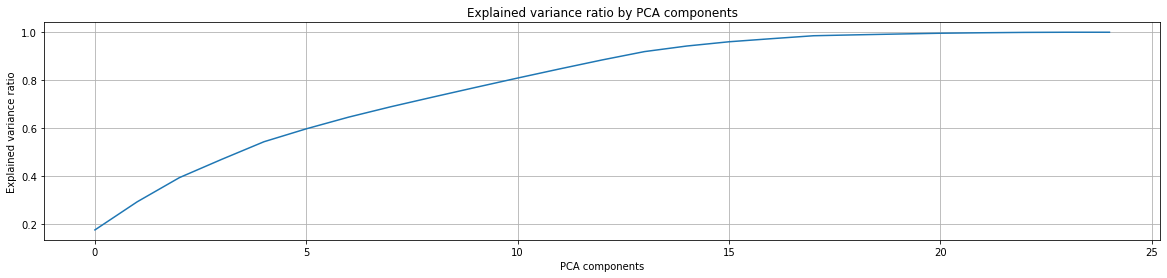

In [18]:
# import pca
from sklearn.decomposition import PCA
pca = PCA().fit(X)
# Plot the explained variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).plot(
    title='Explained variance ratio by PCA components',
    figsize=(20, 4),
    grid=True,
    xlabel='PCA components',
    ylabel='Explained variance ratio'
)

print('The number of PCA components that explain 70% of the variance is: ', np.where(np.cumsum(pca.explained_variance_ratio_) > 0.70)[0][0] + 1)

In [19]:
pca = PCA(n_components=9).fit(X)
XPC = pca.transform(X)

#### 2.3 Clustering!

Below is our implementation of K-means clustering using map-reduce. We have created 2 functions to assist in the clustering process:
1. `assign_cluster`: This function takes a data point and the centroids as the input, and finds the closest centroid. It then passes the index of the closest centroid, and a tuple of 1 and the data point as the output. This is because we want to keep track of the number of data points in each cluster. This function is used in the **map** step of the map-reduce algorithm.
2. `update_centroids`: This function takes the output of the `assign_cluster` function, and calculates the sum of the data points and the number of data points in each cluster. This function is used in the **reduce** step of the map-reduce algorithm.

Afterwards, we take the results of the map-reduce algorithm, and calculate the new centroids by dividing the sum of the data points by the number of data points in each cluster.

In [20]:
from pyspark import SparkContext

def assign_cluster(row, centroids):
    cluster = np.argmin(np.sum((centroids - row) ** 2, axis=1))
    return (cluster, (1, row))

def update_centroids(x, y):
    # Returns the sum of number of observations and the sum of the rows
    return (x[0] + y[0], x[1] + y[1])

def kmeans(X, k, max_iter=10, epsilon=0.0001, verbose=True):
    sc = SparkContext.getOrCreate()
    rdd = sc.parallelize(X)

    centroids = X[np.random.choice(X.shape[0], k, replace=False), :]
    sse = np.inf

    for j in (pbar:= tqdm(range(max_iter), desc='KMeans iterations')):
        mapResults = rdd.map(lambda x: assign_cluster(x, centroids)).reduceByKey(update_centroids).collect()
        centroids = np.array([mapResults[i][1][1] / mapResults[i][1][0] for i in range(k)])
 
        clusters = [row[0] for row in rdd.map(lambda x: assign_cluster(x, centroids)).collect()]
        new_sse = np.sum((np.dot(pd.get_dummies(clusters).values, centroids) - X) ** 2)
        
        if (new_sse / sse) > (1 - epsilon):
            if verbose:
                print(f'Converged, in {j + 1} iterations :))')
            break
        
        if verbose:
            pbar.set_description(f'KMeans iterations {j + 1}/{max_iter} (SSE: {sse:.2f}), rate: {(new_sse / sse):.5f}')
        sse = new_sse

    return clusters, centroids, sse

In [38]:
number_of_clusters_grid = [2, 3, 4, 5, 6, 7, 8, 9, 10]
sse_scores = np.inf * np.ones(len(number_of_clusters_grid))
num_rep = 1

for i, k in enumerate(number_of_clusters_grid):
    for j in range(num_rep):
        _, _, sse_score = kmeans(XPC, k, 50, verbose=False)
        if sse_score < sse_scores[i]:
            sse_scores[i] = sse_score

pd.Series(sse_scores, index=number_of_clusters_grid).plot(
    title='SSE by number of clusters',
    figsize=(20, 4),
    grid=True,
    xlabel='Number of clusters',
    ylabel='SSE'
)

KMeans iterations:  14%|█▍        | 7/50 [00:16<01:40,  2.34s/it]               


KeyboardInterrupt: 

We were planning to support our decision with the elbow method, however, as you can see on the plot above, there are no clear "elbows". Practically, banks want customer segments that are easy to understand, and reflect real life. So we believe that the number of clusters should be between 3 and 7. Looking at the plot we see decreases in 4 and 6, so we will continue with these two numbers.

In [50]:
clusters4, centroids4, _ = kmeans(XPC, 4, 50, verbose=False)
clusters6, centroids6, _ = kmeans(XPC, 6, 50, verbose=False)

KMeans iterations:  32%|███▏      | 16/50 [00:18<00:39,  1.15s/it]              


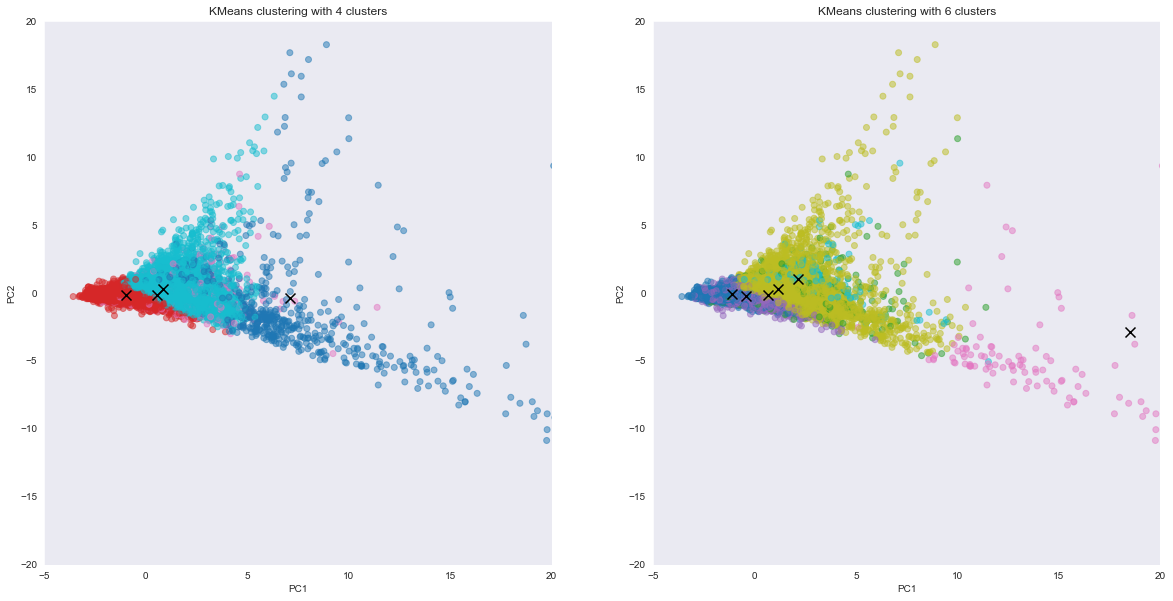

In [52]:
import matplotlib.pyplot as plt
# Plot according to the first two principal components
fig, axs = plt.subplots(1, 2, figsize=(20, 10))


# Scaterplot with 4 clusters
axs[0].scatter(XPC[:, 0], XPC[:, 1], c=clusters4, cmap='tab10', alpha=0.5)
axs[0].scatter(centroids4[:, 0], centroids4[:, 1], marker='x', s=100, c='k')
axs[0].set_title('KMeans clustering with 4 clusters')
axs[0].set_xlabel('PC1'); axs[0].set_ylabel('PC2')
axs[0].set_xlim(-5,20); axs[0].set_ylim(-20,20)
axs[0].grid()

# Scaterplot with 6 clusters
axs[1].scatter(XPC[:, 0], XPC[:, 1], c=clusters6, cmap='tab10', alpha=0.5)
axs[1].scatter(centroids6[:, 0], centroids6[:, 1], marker='x', s=100, c='k')
axs[1].set_title('KMeans clustering with 6 clusters')
axs[1].set_xlabel('PC1'); axs[1].set_ylabel('PC2')
axs[1].set_xlim(-5,20); axs[1].set_ylim(-20,20)
axs[1].grid()

plt.show()


#### 2.4 Analysing your results!

Now we select 2-3 variables, that is; gender, age, balance; to create our pivot table.

In [55]:
customersX['clusters4'] = clusters4
customersX['clusters6'] = clusters6

selected_variables = ['age', 'gender', 'balance']
cust4pivot = customersX.copy()

cust4pivot['age_group'] = pd.qcut(customersX['age'], 4, labels=False)
cust4pivot['balance_group'] = pd.qcut(customersX['balance'], 4, labels=False)

# make dummies
cust4pivot = pd.get_dummies(cust4pivot, columns=['gender', 'age_group', 'balance_group'])

# pivot table
cols = ['gender_0', 'gender_1', 'age_group_0', 'age_group_1', 'age_group_2', 'age_group_3', 'balance_group_0', 'balance_group_1', 'balance_group_2', 'balance_group_3']
cust4pivot = cust4pivot.pivot_table(index='clusters4', values=cols, aggfunc='mean')
pd.options.display.float_format = '{:,.2f}'.format

cust4pivot.columns = ['below 25', '25 to 28', '28 to 34', '34+', 'below 5240 INR', '5240 to 17230 INR', '17230 to 55530 INR', '55530+ INR', 'F', 'M']
cust4pivot = 100 * cust4pivot
cust4pivot

,below 25,25 to 28,28 to 34,34+,below 5240 INR,5240 to 17230 INR,17230 to 55530 INR,55530+ INR,F,M
clusters4,,,,,,,,,,
0,5.98,6.91,15.69,71.41,10.64,10.90,19.68,58.78,29.65,70.35
1,40.86,23.31,23.76,12.07,41.83,38.01,19.36,0.79,23.79,76.21
2,28.17,22.51,27.61,21.71,17.65,25.35,29.81,27.18,28.25,71.75
3,15.43,18.05,30.43,36.09,1.32,4.62,32.80,61.26,36.64,63.36


From this table we can see age, balance, and gender distribution of each cluster. For example, cluster 2 is older, and cluster 1 is the richest. However, we had a different approach of analysis and here is how we did it. We calculated the difference between the mean of each variable in each cluster and the mean of the whole dataset. We then sorted the clusters based on the difference of the mean of the variable. We then plotted the difference of the mean of the variable for each cluster.

In [56]:
variables_to_inspect = ['age', 'gender', 'balance', 'log_balance', 'avg_tamount', 'top_30_loc', 'transaction_freq']
variables_to_inspect = [*customersX.columns[1:2], *customersX.columns[4:25]]
customersX['clusters4'] = clusters4
customersX['clusters6'] = clusters6
customersX['gender'] = customersX['gender'].apply(lambda x: 1 if x == 'M' else 0)

c4stomers = customersX.groupby('clusters4').agg({col: 'mean' for col in variables_to_inspect})
(c4stomers - customersX[variables_to_inspect].mean()) / customersX[variables_to_inspect].std()
# merge with columns
Z_scores = (c4stomers - customersX[variables_to_inspect].mean()) / customersX[variables_to_inspect].std()

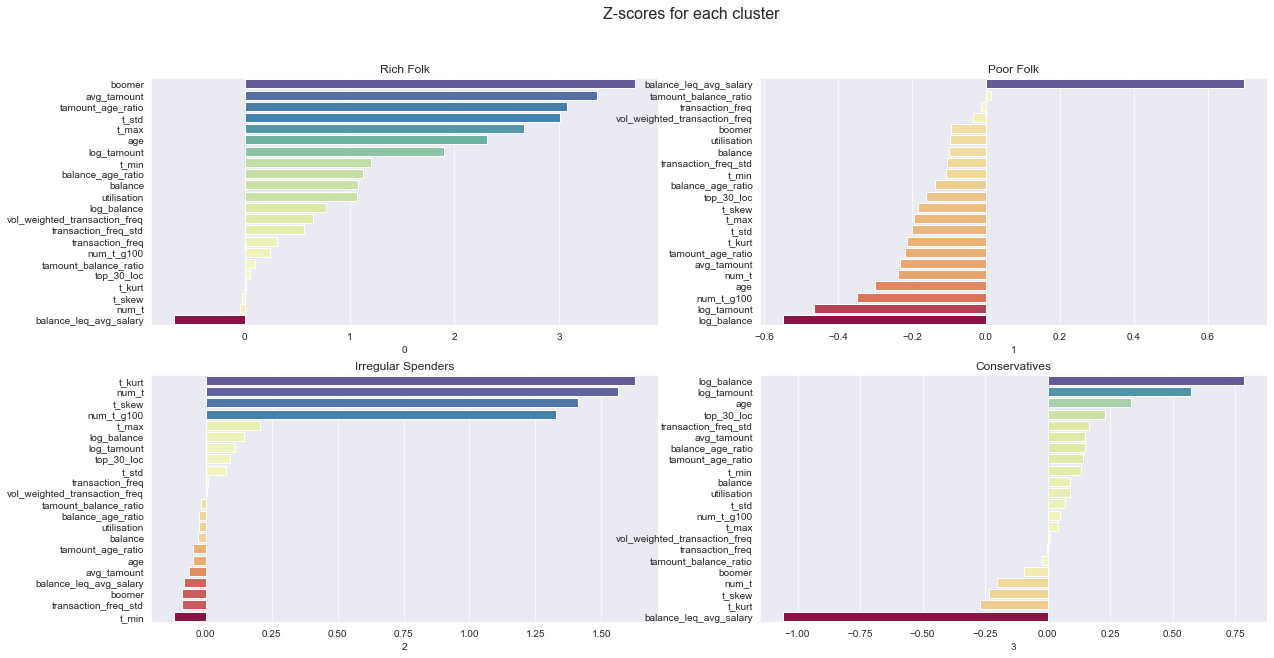

In [60]:
import seaborn as sns
import itertools
sns.set_style('darkgrid')
# Bar plot
def colors_from_values(values, palette_name):
    maximum = max(Z_scores.abs().max())
    # normalize the values to range [0, 1]
    normalized = values
    normalized[normalized < 0] = - normalized[normalized < 0] / normalized.min() * 500
    normalized[normalized > 0] = normalized[normalized > 0] / normalized.max() * 500 -1
    normalized = normalized + 500
    # convert to indices
    indices = np.round(normalized).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, 1000)
    return np.array(palette).take(indices, axis=0)

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

fig.suptitle('Z-scores for each cluster', fontsize=16)
cluster_names = ['Rich Folk', 'Poor Folk', 'Irregular Spenders', 'Conservatives']
for i, j in itertools.product(range(2), range(2)):
    # bar plot
    k = i*2 + j
    sns.barplot(x=Z_scores.iloc[k, :].sort_values(ascending=False), y=Z_scores.iloc[k, :].sort_values(ascending=False).index,
    ax=axs[i, j], palette=colors_from_values(Z_scores.iloc[k, :].sort_values(ascending=False), 'Spectral'), orient = 'h')
    axs[i, j].set_title(cluster_names[k])

plt.show()

From the pivot table we get a general idea of clusters. However, we thought it did not unravel the complete story. So we decided to look at the clusters features in terms of their distance from to overall means. In the plot above, you can see the distance of each cluster from the overall mean. The features that have distances with high magnitude characterize their clusters. So here is our interpretation of the clusters:

**Cluster 1**: This cluster is characterized by the fact that the customers have dispersed spending habits, because their kurtosis and skewness for their transaction amounts are high compared to the rest of dataset. Their minimum transactions are very low and maximum are very high, which means they use their cards for any kind of spending. As a bank we would like identify these customers of being more adapted to the digital world, and offer them more digital services.

**Cluster 2**: This cluster is the poor people. They have balances lower than the average salary. This means that they are more likely default on their payments. As a bank we would be more careful with these customers, and offer them more services that would help them manage their finances better.

**Cluster 3**: We can label this cluster as the "conservatives" or "traditionalists". They have low number of transactions, and relatively old. They only use their cards to pay very high amounts. This means that they do not use their cards for small purchases. As a bank we would target them as customers with more potential to spend, and try to educate them on the benefits of using their cards for small purchases.

**Cluster 4**: Eat the rich. This cluster is characterized by the fact that they have very high balances, and very high transaction amounts. They are also very old and boomer. We would offer them personalized services, and try to make them feel special. For example, lounge access, and private transfers etc.

### Bonus

In [ ]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering

dbscan = DBSCAN(eps=0.3, min_samples=10).fit(XPC[:, :2])

plt.figure(figsize=(10, 10))

plt.scatter(XPC[:, 0], XPC[:, 1], c=dbscan.labels_, cmap='tab10', alpha=0.5)
plt.title('DBSCAN clustering')

plt.xlabel('PC1'); plt.ylabel('PC2')
plt.xlim(-5,20); plt.ylim(-20,20)
plt.show()

Our data is very dense, in the center and sparse in the edges. This is because, economically, the majority of the population is in the low-middle class, and the upper class is very small. As a result, DBSCAN groups all low and middle class customers together, and leaves the upper class customers alone. The distance between the middle and lower class is very small compared to the distance between the upper class and the middle class. Therefore density is not a good measure and **DBSCAN** is not a good clustering method for our data.

In [ ]:
hierarchical = AgglomerativeClustering(
    n_clusters=None, 
    linkage='ward',
    distance_threshold = 7
).fit(XPC)

In [ ]:
# import dendrogram
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count +=1
            else:
                current_count += counts[child_idx-n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                     counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

fig, ax = plt.subplots(figsize = (20,10))
ax.set_title("Hierarchical clustering dendrogram")
#plot the top three levels of the dendrogram
plot_dendrogram(hierarchical, truncate_mode='level', p=7)
ax.set_xlabel("Number of points in node")
plt.show()

# This code is inspired from Philip Wilkinson's post on Towards Data Science

In [ ]:
# hierarchical clustering with 4 clusters
hierarchical4 = AgglomerativeClustering(
    n_clusters=4,
    linkage='ward',
    distance_threshold = None
).fit(XPC)

# get the cluster labels
hierarchical4.labels_

In [ ]:
customersX['hierarchical4'] = hierarchical4.labels_
customers_h4 = customersX.groupby('hierarchical4').agg({col: 'mean' for col in variables_to_inspect})
Z_h4 = (customers_h4 - customersX[variables_to_inspect].mean()) / customersX[variables_to_inspect].std()

for i in range(4):
    print(f'Top explanatory features for Cluster {i+1}')
    t = Z_h4.loc[i, Z_h4.iloc[i, :].abs().sort_values(ascending=False)[:5].index].sort_values(ascending=False)
    for j in range(len(t)):
        print(f'{j+1}. {t.index[j]}: \t \t {t.iloc[j].round(2)}')
    

For hierarchical clustering, we have decided to inspect 4 clusters. One immediate observation is that the some clusters are way more marginal compared to the results we got in K-means. As you can see, cluster 1 and 4 has features that are very distant from the mean, which is a sign of being even more charactestic. For example, cluster 4 are people with very high balance and age. In our previous results we have also identified a segment of rich customers, however, the results we get from hierarchical clustering are more extreme. We can further our analysis looking into more clusters, that is, dividing up the current clusters into more clusters. And doing so we can better understand the segments of customers. We think this is a good method to use for a bank to understand their customers, where computational power is not a concern.

In [ ]:
# import kmeans from sklearn
from sklearn.cluster import KMeans


n_clusters = 3
kmeans_sk = KMeans(n_clusters=n_clusters)
rows = 5
fig, axs = plt.subplots(rows, 2, figsize=(20, 25))

for i in range(rows):
    kmeans_sk.fit(XPC[:, :2])
    axs[i, 0].scatter(XPC[:, 0], XPC[:, 1], c=kmeans_sk.labels_, cmap='tab10', alpha=0.5)
    axs[i, 0].set_title(f'K-means clustering (sklearn) {i+1}')
    axs[i, 0].set_xlabel('PC1'); axs[i, 0].set_ylabel('PC2')
    axs[i, 0].set_xlim(-5,20); axs[i, 0].set_ylim(-20,20)

    clusters, centroids, _ = kmeans(XPC[:, :2], k=n_clusters, max_iter=100, verbose=False)
    axs[i, 1].scatter(XPC[:, 0], XPC[:, 1], c=clusters, cmap='tab10', alpha=0.5)
    axs[i, 1].set_title(f'K-means clustering (our code) {i+1}')
    axs[i, 1].set_xlabel('PC1'); axs[i, 1].set_ylabel('PC2')
    axs[i, 1].set_xlim(-5,20); axs[i, 1].set_ylim(-20,20)

plt.show()



In our code we initialize randomly and the module we have imported from sklearn initialize with KMeans++. In the plot above, you can observe that the module we have imported from sklearn always has only 2 large clusters, and the third is not even visible. On the other hand, in some of the results that we get from our code has 3 balanced clusters. This is due to the nature of clustering processes. Clustering, in the end, has qualitative implications, and sometimes quantitative metrics do not give a good picture of the results. Surprisingly, our code does a better job in having more balanced clusters, if that is what you are looking for.

#### Summary of clustering comparison

All in all, we have learned that not every clustering algorithm fits every dataset. In our case, DBSCAN is not a good choice because of the distribution of our data, compared to K-means and hierarchical clustering. Moreover, the motivation behind the clustering is also a factor that should be considered. For example, if you want to have a balanced number of clusters, in our case, K-means with random initiliziation produced better results. Finally, we think that if our goal is to do qualitative analysis, then we should use hierarchical clustering, since it provides sub-clusters, and we can further our analysis by looking into the sub-clusters.

### Command Line Question

In [ ]:
%%bash

echo '1-The location that has the maximum number of purchases been made:'

awk -F, '{print($5)}' data/bank_transactions.csv | sort | uniq -c | sort -nr | head -1

echo '2-The most spending purchases are: '

awk -F, '{$4+=$9}END{ if(list["F"] > list["M"]){ print("F");} else{ print("M");}}' data/bank_transactions.csv

echo '3-The customer with the highest average transaction amount: '

awk -F, 'BEGIN{FS=","} {if(NR>1){arr[$2]= arr[$2]+$9; count[$2]++}} END{for(c in arr){arr[c]= arr[c]/count[c]} asort(arr, sortedarr);for(l in arr){if(arr[l]==sortedarr[length(sortedarr)])print arr[l], l}}' bank_transactions.csv

### Algorithmic Question

In [ ]:
def check_enough_guards(N: int, M: int, G: int, arriving: list):
    """
    Check if there are enough guards to protect the gates
    """
    enough  = True # do we have enough guards?
    history = {}   # history of first and last time a student visited a gate

    for i, student in enumerate(arriving):

        if student not in history.keys():
            history[student] = [i, -1] # first time, last time
        else:
            history[student][1] = i    # update last time
        

    for i in range(N):
        intersections = 0

        for gate in history.keys():
            if history[gate][0] <= i <= history[gate][1]:
                intersections += 1
        
        if intersections > G:
            enough = False
            break

    print('YES') if enough else print('NO')
    # print(history, interactions)

## Case 1
arriving = [1, 1, 3, 3, 3]
#arriving = [3, 3, 1, 1, 3, 3, 2, 2, 3, 3, 2, 2,]

N, M, G = 4, len(arriving), 1

print(f'N = {N}, M = {M}, G = {G}, arriving = {arriving}')
check_enough_guards(N, M, G, arriving)


# Case 2
arriving = [1, 2, 1, 2, 2]
N, M, G = 2, len(arriving), 1

print(f'N = {N}, M = {M}, G = {G}, arriving = {arriving}')
check_enough_guards(N, M, G, arriving)